In [1]:
import numpy as np
import torch
import cv2
from ultralytics.engine.results import Masks

In [2]:
import matplotlib.pyplot as plt

# General set-up

In [3]:
colors = """
#B52CFF
#348F00
#6B2CFF
#FFFF2C
#FF3535
#FF7A00
#0DA3FF
#FFD700
#20C9A5
#E91E63
#D4AC2B
#8CFF00
#FF007A
#2E91E5
#AFFF3C
#C71585
#FF6F00
#009688
#FFCC00
#4A90E2
#00BCD4
#CDDC39
#FF4081
#795548
#FFC400"""

In [4]:
colors = [np.array([int(c[i:i+2], 16) for i in (1, 3, 5)]) for c in colors.split("\n") if c]

In [6]:
img_path = "img/people.jpg"

In [7]:
image = cv2.imread(img_path)

# Get the dimensions of the image
height, width, _ = image.shape

# Set the figure size based on the image dimensions
plt.figure(figsize=(width / 100, height / 100))

<Figure size 1024x683 with 0 Axes>

<Figure size 1024x683 with 0 Axes>

In [8]:
def overlay_masks_on_image(image, results, alpha=0.2, labels=True):
    """
    Overlay masks for multiple instances per class on the original image.

    Args:
        image: Original image (as a NumPy array).
        masks: Dictionary where each key is a class ID, and the value is a list of binary masks (one for each instance).
        alpha: Transparency of the overlay (0 = transparent, 1 = opaque).
    """

    for c, obj in zip(results[0].boxes.cls.type(torch.int).numpy(), results[0].masks.xy):

        # Convert the polygon coordinates to integer
        polygon = np.array(obj, dtype=np.int32)

        # Get the color for the current class
        color = colors[c % len(colors)]

        # Create a mask for the polygon
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 1)

        # Create a color mask (with the same shape as the image)
        color_mask = np.zeros_like(image)
        color_mask[mask == 1] = color

        # Overlay the mask on the image using the transparency factor
        image = cv2.addWeighted(image, 1, color_mask, alpha, 0)

        # Draw the polygon outline on the image
        image = cv2.polylines(image, [polygon], isClosed=True, color=color.tolist(), thickness=2, lineType=cv2.LINE_AA)

        if True:
            # Find the centroid of the mask to place the label
            moments = cv2.moments(mask)
            if moments["m00"] != 0:
                cX = int(moments["m10"] / moments["m00"])
                cY = int(moments["m01"] / moments["m00"])
                class_name = results[0].names[c]
                        
                # Get the text size
                text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.65, 2)[0]
                        
                # Create a white background for the text with larger padding
                text_bg = np.full((text_size[1] + 8, text_size[0] + 8, 3), 255, dtype=np.uint8)
                        
                # Ensure the overlay dimensions match the target region in the image
                y1, y2 = cY - text_size[1]//2 - 4, cY + text_size[1]//2 + 4
                x1, x2 = cX - text_size[0]//2 - 4, cX + text_size[0]//2 + 4
                y1, y2 = max(0, y1), min(image.shape[0], y2)
                x1, x2 = max(0, x1), min(image.shape[1], x2)
                text_bg = text_bg[:y2-y1, :x2-x1]
                        
                # Overlay the text background on the image
                image[y1:y2, x1:x2] = text_bg
                        
                # Put the text on the image
                cv2.putText(image, class_name, (cX - text_size[0]//2, cY + text_size[1]//2), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0), 2)

    return image

In [10]:
image = cv2.imread(img_path)

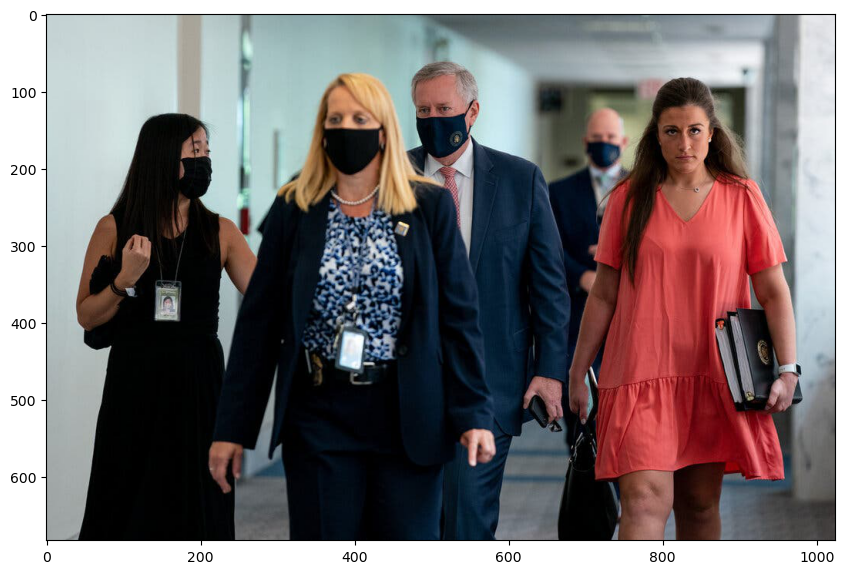

In [11]:
plt.figure(figsize=(width / 100, height / 100))
plt.imshow(image[...,::-1])

# Mask R-CNN

In [19]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-u55wkrc6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-u55wkrc6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 7.8 MB/s eta 0:00:00a 0:00:01
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 8.6 MB/s eta 0:00:00a 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x

In [22]:
import torch, detectron2

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [31]:
"device" in str(cfg).lower()

True

In [32]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE = "cpu"
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[10/27 21:01:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:29, 6.06MB/s]                              


In [33]:
outputs = predictor(image)

/home/kk/miniconda3/envs/magic9/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [35]:
outputs["instances"].pred_classes

tensor([ 0,  0,  0,  0,  0, 26, 27, 67, 67, 67,  0])

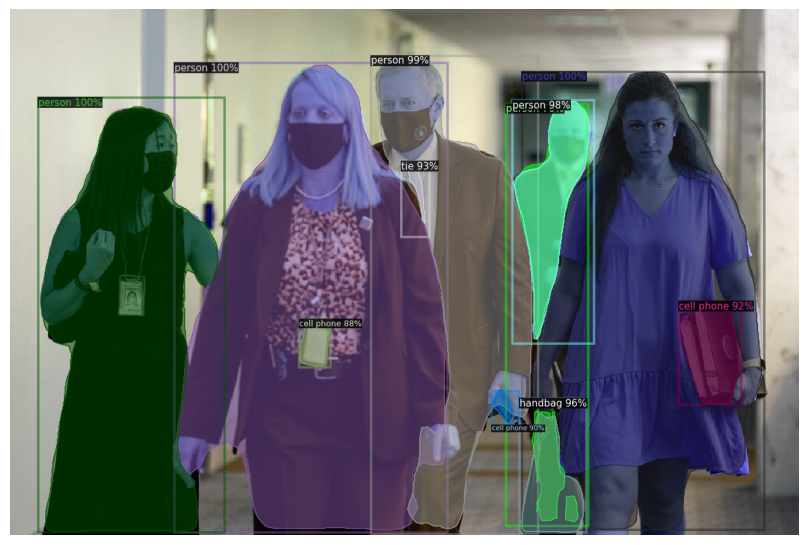

In [37]:
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"])

plt.figure(figsize=(width / 100, height / 100))
# Display the image
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')  # Hide the axis
plt.show()

# DeepLabV3

In [94]:
from torchvision.io.image import decode_image
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.transforms.functional import to_pil_image

In [95]:
# Step 1: Initialize model with the best available weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights)
model.eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/kk/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:39<00:00, 6.21MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [96]:
img = torch.tensor(image, dtype=torch.uint8).permute(2, 0, 1)
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

In [97]:
# Step 4: Use the model and visualize the prediction
prediction = model(batch)["out"]

In [98]:
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["person"]]

In [99]:
weights.meta["categories"]

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [100]:
class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

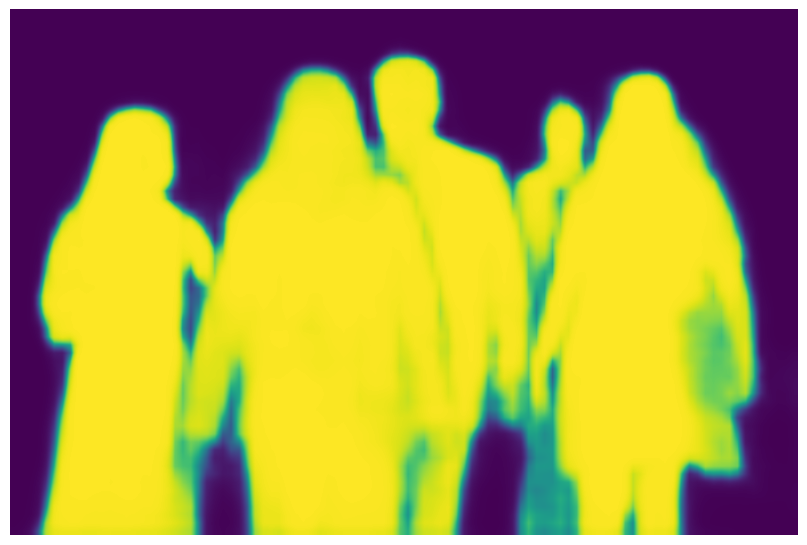

In [101]:
plt.figure(figsize=(width / 100, height / 100))
# Display the image
plt.imshow(mask.detach().numpy())
plt.axis('off')  # Hide the axis
plt.show()

# YOLO

In [12]:
from ultralytics import YOLO

# Build a YOLOv9c model from pretrained weight
model = YOLO("yolov9c-seg.pt")

# Display model information (optional)
model.info()

# Run inference with the YOLOv9c model on the 'bus.jpg' image
results = model(img_path)

YOLOv9c-seg summary: 654 layers, 27,897,120 parameters, 0 gradients

image 1/1 /media/local/the last one/images/img/people.jpg: 448x640 6 persons, 2 handbags, 1 tie, 2 cell phones, 9866.0ms
Speed: 95.0ms preprocess, 9866.0ms inference, 55.5ms postprocess per image at shape (1, 3, 448, 640)


In [13]:
len(results[0]), len(results[0].masks), len(results[0].masks.data)

(11, 11, 11)

In [17]:
# Overlay masks on the image
output_image = overlay_masks_on_image(image, results)

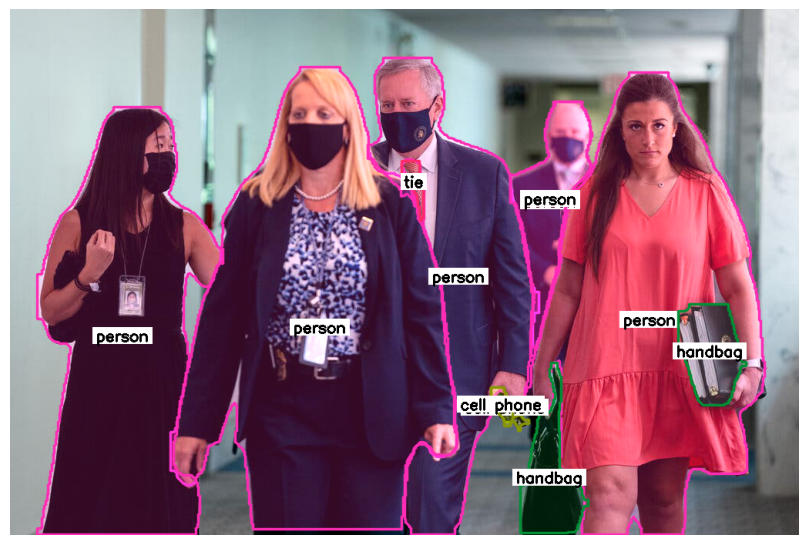

In [18]:
plt.figure(figsize=(width / 100, height / 100))
# Display the image
plt.imshow(output_image[..., ::-1])
plt.axis('off')  # Hide the axis
plt.show()